In [1]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets as dst
from torchvision.transforms import transforms
from torch import optim
import random
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import torch.nn as nn

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [4]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
class TestDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        x0_tuple = random.choice(self.imageFolderDataset.imgs)
        #get more image
        while True:
            #keep looping till the same class image is found
            x1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if x0_tuple[1]==x1_tuple[1]:
                break
        
        # get diffrent class
        while True:
            y_tuple = random.choice(self.imageFolderDataset.imgs) 
            if x0_tuple[1] != y_tuple[1]:
                break
                
        # get diffrent class
        while True:
            z_tuple = random.choice(self.imageFolderDataset.imgs) 
            if x0_tuple[1] != z_tuple[1]:
                break
                
        x0 = Image.open(x0_tuple[0])
        x1 = Image.open(x1_tuple[0])
        
        y = Image.open(y_tuple[0])
        z = Image.open(z_tuple[0])
        
        x0 = x0.convert("L")
        x1 = x1.convert("L")
        y = y.convert("L")
        z = z.convert("L")
        
        if self.should_invert:
            x0 = PIL.ImageOps.invert(x0)
            x1 = PIL.ImageOps.invert(x1)
            y = Image.open(y)
            z = Image.open(z)

        if self.transform is not None:
            x0 = self.transform(x0)
            x1 = self.transform(x1)
            y = self.transform(y)
            z = self.transform(z)
        
        return x0, x1,y,z
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [7]:
def show_plot(counter,loss_history):
    plt.plot(counter,loss_history)
    plt.title('Loss')
    plt.show()

# training

In [8]:
train_dir = "./att-database-of-faces/train"

In [9]:
folder_dataset_train = dst.ImageFolder(root=train_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

train_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

In [10]:
folder_dataset_train

Dataset ImageFolder
    Number of datapoints: 210
    Root location: ./att-database-of-faces/train

In [11]:
train_dataloader

In [12]:
img0,img1,label = next(iter(train_dataloader))

In [13]:
grid = torchvision.utils.make_grid(torch.cat([img0,img1]))

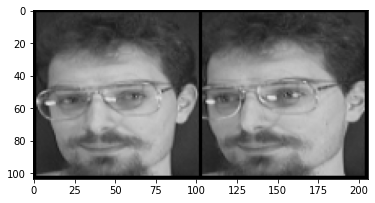

In [14]:
plt.imshow(grid.permute(1,2,0))

In [15]:
label # 0 for same and 1 not same

tensor([[0.]])

In [16]:
torch.cuda.empty_cache()

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00005)

counter = []
loss_history = [] 
iteration_number = 0
train_number_epochs = 100

for epoch in range(0,train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            #print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
torch.save(net.state_dict(), './weights/same_network_Adam_1_epcho_train.pth')
show_plot(counter,loss_history)

# Tesing the model

In [52]:
PATH = './weights/same_network_12_epcho_train.pth'

In [57]:
model_test = SiameseNetwork()

In [58]:
model_test.load_state_dict(torch.load(PATH))
model_test.eval()


SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace)
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (12): ReLU(inplace)
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.2)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
 

In [61]:
test_dir = "./att-database-of-faces/test"

In [63]:
folder_dataset_test = dst.ImageFolder(root=test_dir)
siamese_dataset = TestDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)



test_dataloader = DataLoader(siamese_dataset,num_workers=1,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)


number_of_iter = 2
error = 0
right = 0

for i in range(1,number_of_iter):
    results = []
    
    try:
        x0,x1,y,z = next(dataiter) 
    except StopIteration:
        # reinitialize data loader 
        dataiter = iter(test_dataloader)
        x0,x1,y,z = next(dataiter) 
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())

    euclidean_distance = F.pairwise_distance(output1, output2)
    x0x1 = euclidean_distance.item()

    results.append(x0x1)

    output1,output2 = net(Variable(x0).cuda(),Variable(y).cuda())

    euclidean_distance = F.pairwise_distance(output1, output2)
    x0y = euclidean_distance.item()

    results.append(x0y)


#     output1,output2 = net(Variable(x0).cuda(),Variable(z).cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     x0z = euclidean_distance.item()
#     results.append(x0z)

    if(min(results) == x0x1):
        right += 1
    else:
        error += 1 
        
#     x1_cpu = torchvision.transforms.ToPILImage()(x1.squeeze(0))
#     x0_cpu = torchvision.transforms.ToPILImage()(x0.squeeze(0))

#     contact  = np.concatenate([x0_cpu,x1_cpu],axis=0)
   
#     plt.xlabel('Dissimilarity:'+str(x0x1)[:10])
#     plt.imshow(contact,cmap="gray")
    
print("acc {}".format(right / number_of_iter))
print("err {}".format(error / number_of_iter))


    
#plt.show()

acc 0.5
err 0.0
